# Clustering by neighbourhood

Objecive: find which problems are more common in each neighbourhood

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from kneed import KneeLocator

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import silhouette_score

In [78]:
df = pd.read_csv('db_criminalBehaviour_byNeighbourhood.csv')
df.drop(['categories', 'Unnamed: 0', 'index'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45218 entries, 0 to 45217
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            45218 non-null  int64 
 1   month           45218 non-null  int64 
 2   week_day        45218 non-null  object
 3   regional_name   45218 non-null  object
 4   problem_type_1  45218 non-null  object
 5   count           45218 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 2.1+ MB


In [137]:
df_groupped = df.groupby(['regional_name']).count()['count']
df_groupped

regional_name
BAIRRO NOVO              4066
BOA VISTA                5019
BOQUEIRÃO               4988
CAJURU                   4273
CIC                      3956
MATRIZ                   8667
PINHEIRINHO              3900
PORTÃO                  5072
REGIÃO METROPOLITANA      67
SANTA FELICIDADE         3765
TATUQUARA                1445
Name: count, dtype: int64

In [139]:
table = pd.pivot_table(df, values='count', index=['regional_name'],
                       columns=['year','month'], aggfunc=np.sum)
table

year                    2009                                               \
month                     1      2     3      4      5     6     7     8    
regional_name                                                               
BAIRRO NOVO             27.0   13.0   8.0   12.0   12.0  12.0  14.0  10.0   
BOA VISTA               37.0   29.0  37.0   36.0   41.0  29.0  26.0  42.0   
BOQUEIRÃO              30.0   25.0  30.0   48.0   32.0  24.0  40.0  28.0   
CAJURU                  23.0   17.0  17.0   22.0   22.0  23.0  19.0  14.0   
CIC                     35.0   22.0  30.0   24.0   23.0  20.0  17.0  22.0   
MATRIZ                 114.0  116.0  95.0  103.0  106.0  99.0  91.0  88.0   
PINHEIRINHO             22.0   20.0  19.0   24.0   13.0  13.0  18.0  16.0   
PORTÃO                 38.0   36.0  53.0   44.0   45.0  43.0  39.0  28.0   
REGIÃO METROPOLITANA    1.0    NaN   NaN    NaN    NaN   NaN   NaN   NaN   
SANTA FELICIDADE        27.0   21.0  33.0   33.0   19.0  16.0  20.0  27.0   
TATUQUARA                NaN    NaN   NaN    NaN    NaN   NaN   NaN   NaN   

year                               ...   2022                              \
month                    9     10  ...     3      4      5      6      7    
regional_name                      ...                                      
BAIRRO NOVO            15.0   9.0  ...   57.0   59.0   64.0   40.0   51.0   
BOA VISTA              29.0  32.0  ...   72.0   83.0   60.0   45.0   42.0   
BOQUEIRÃO             35.0  23.0  ...   66.0   48.0   61.0   62.0   55.0   
CAJURU                 19.0  27.0  ...   68.0   51.0   55.0   59.0   53.0   
CIC                    21.0  23.0  ...   76.0   60.0   50.0   58.0   48.0   
MATRIZ                 93.0  96.0  ...  219.0  195.0  200.0  162.0  170.0   
PINHEIRINHO            12.0  13.0  ...   69.0   49.0   52.0   50.0   45.0   
PORTÃO                28.0  25.0  ...   53.0   59.0   62.0   51.0   61.0   
REGIÃO METROPOLITANA   NaN   NaN  ...    NaN    1.0    NaN    NaN    NaN   
SANTA FELICIDADE       28.0  31.0  ...   20.0   20.0   15.0   26.0   33.0   
TATUQUARA               NaN   NaN  ...   40.0   32.0   32.0   29.0   31.0   

year                                                     
month                     8      9      10     11    12  
regional_name                                            
BAIRRO NOVO             30.0   40.0   38.0   35.0   8.0  
BOA VISTA               48.0   40.0   45.0   35.0  14.0  
BOQUEIRÃO              64.0   42.0   41.0   42.0  28.0  
CAJURU                  47.0   34.0   53.0   48.0  18.0  
CIC                     49.0   58.0   48.0   37.0  21.0  
MATRIZ                 164.0  167.0  190.0  132.0  62.0  
PINHEIRINHO             38.0   43.0   54.0   41.0  11.0  
PORTÃO                 47.0   29.0   54.0   41.0  19.0  
REGIÃO METROPOLITANA    1.0    NaN    NaN    NaN   3.0  
SANTA FELICIDADE        23.0   33.0   24.0   17.0   7.0  
TATUQUARA               20.0   22.0   33.0   25.0  16.0  

[11 rows x 168 columns]

In [149]:
# table.loc[:,2009]
# table.loc[:,2010]
# table.loc[:,2011]
table.loc[:,2012]
# table.loc[:,2013]
# table.loc[:,2014]
# table.loc[:,2015]
# table.loc[:,2016]
# table.loc[:,2017]
# table.loc[:,2018]
# table.loc[:,2019]
# table.loc[:,2020]
# table.loc[:,2021]
# table.loc[:,2022]


month,1,2,3,4,5,6,7,8,9,10,11,12
regional_name,,,,,,,,,,,,
BAIRRO NOVO,28.0,34.0,31.0,43.0,37.0,16.0,36.0,43.0,37.0,38.0,24.0,38.0
BOA VISTA,48.0,43.0,36.0,38.0,58.0,26.0,38.0,59.0,64.0,55.0,51.0,45.0
BOQUEIRÃO,63.0,49.0,76.0,63.0,48.0,37.0,36.0,39.0,29.0,28.0,23.0,31.0
CAJURU,27.0,24.0,25.0,22.0,19.0,22.0,22.0,23.0,33.0,34.0,32.0,33.0
CIC,30.0,25.0,30.0,32.0,33.0,15.0,21.0,16.0,23.0,21.0,24.0,18.0
MATRIZ,140.0,178.0,222.0,227.0,148.0,149.0,139.0,168.0,175.0,188.0,222.0,175.0
PINHEIRINHO,35.0,23.0,32.0,32.0,16.0,15.0,26.0,27.0,32.0,27.0,28.0,25.0
PORTÃO,43.0,38.0,49.0,54.0,48.0,37.0,45.0,49.0,42.0,54.0,55.0,24.0
REGIÃO METROPOLITANA,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0


In [150]:
table = pd.pivot_table(df, values='count', index=['problem_type_1'],
                       columns=['regional_name'], aggfunc=np.sum)
table

regional_name,BAIRRO NOVO,BOA VISTA,BOQUEIRÃO,CAJURU,CIC,MATRIZ,PINHEIRINHO,PORTÃO,REGIÃO METROPOLITANA,SANTA FELICIDADE,TATUQUARA
problem_type_1,,,,,,,,,,,
Abandonment/nonsupport of incompetent person,11.0,21.0,19.0,14.0,18.0,28.0,17.0,21.0,NaN,8.0,3.0
Abuse of incapacitated persons,9.0,4.0,9.0,5.0,2.0,12.0,1.0,3.0,NaN,4.0,2.0
Agression,183.0,473.0,365.0,291.0,192.0,2037.0,300.0,452.0,2.0,321.0,34.0
Animal abuse,4.0,8.0,6.0,12.0,6.0,18.0,6.0,6.0,NaN,2.0,3.0
Arbitrary violence,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Theft,500.0,689.0,920.0,725.0,571.0,3618.0,589.0,984.0,9.0,459.0,177.0
"Theft, loss, recovery, seizure of firearms",3.0,1.0,7.0,9.0,4.0,20.0,2.0,9.0,NaN,4.0,1.0
Violation of Protective Measures for women - Lei Maria da Penha,515.0,634.0,424.0,618.0,599.0,289.0,299.0,354.0,1.0,282.0,373.0


In [152]:
table.describe()

regional_name,BAIRRO NOVO,BOA VISTA,BOQUEIRÃO,CAJURU,CIC,MATRIZ,PINHEIRINHO,PORTÃO,REGIÃO METROPOLITANA,SANTA FELICIDADE,TATUQUARA
count,44.000000,42.000000,51.000000,45.000000,40.000000,60.000000,38.000000,48.000000,14.000000,39.000000,30.000000
mean,149.704545,195.642857,172.803922,146.244444,154.950000,535.650000,150.000000,179.291667,4.928571,133.410256,65.666667
std,359.368929,436.795751,461.531668,335.980529,357.127568,1795.712944,314.982024,449.098291,5.356007,273.464297,136.549431
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,3.250000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,3.000000,1.250000
50%,6.000000,9.500000,7.000000,9.000000,13.000000,16.000000,10.000000,6.000000,2.500000,8.000000,4.000000
75%,53.500000,84.250000,52.000000,39.000000,62.750000,60.000000,76.000000,60.750000,7.750000,91.500000,33.500000
max,1447.000000,1861.000000,2517.000000,1472.000000,1809.000000,11334.000000,1298.000000,2171.000000,17.000000,1120.000000,602.000000


In [154]:
table = pd.pivot_table(df, values='count', index=['regional_name'],
                       columns=['problem_type_1'], aggfunc=np.sum)
table.mean()

problem_type_1
Abandonment/nonsupport of incompetent person                                   16.000000
Abuse of incapacitated persons                                                  5.100000
Agression                                                                     422.727273
Animal abuse                                                                    7.100000
Arbitrary violence                                                              1.500000
                                                                                 ...    
Theft                                                                         840.090909
Theft, loss, recovery, seizure of firearms                                      6.000000
Violation of Protective Measures for women - Lei Maria da Penha               398.909091
Violation of graves                                                             3.750000
Wearing a uniform, or badge of a public function that he does not exercise      1.777778
Length

In [79]:
df_raw = df.drop(['problem_type_1'], axis=1)

In [93]:
num_features = ['year', 'month', 'count']
# cat_features = ['problem_type_1']
cat2ord_features = ['week_day', 'regional_name']

In [94]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=4)),
    ('scaler', StandardScaler())])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

cat2ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordEnc', OrdinalEncoder(encoded_missing_value=-1))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        # ('cat', categorical_transformer, cat_features),
        ('ord', cat2ordinal_transformer, cat2ord_features)])

In [95]:
prepr = preprocessor.fit(df_raw)

In [96]:
df_prepr = prepr.transform(df_raw)

In [121]:
db = HDBSCAN(min_cluster_size=60).fit(df_prepr)

labels = db.labels_

In [122]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69], dtype=int64)

In [123]:
# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters)
print("Estimated number of noise points: %d" % n_noise)

Estimated number of clusters: 70
Estimated number of noise points: 8387


In [127]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

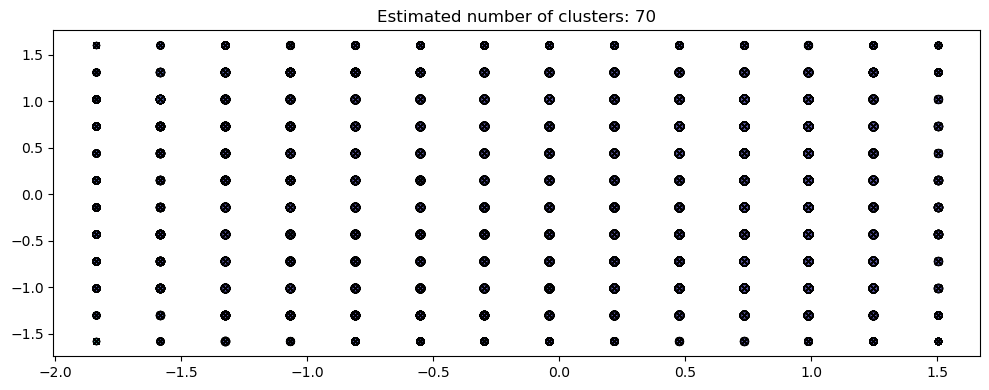

In [128]:
plot(df_prepr, db.labels_, db.probabilities_)

In [124]:
silhouette_score(df_prepr,labels)

0.004266131276275846

In [117]:
nearest_neighbors = NearestNeighbors(n_neighbors=12)
neighbors = nearest_neighbors.fit(df_prepr)

distances, indices = neighbors.kneighbors(df_prepr)
distances = np.sort(distances[:,11], axis=0)


0.5987037970153952


<Figure size 500x500 with 0 Axes>

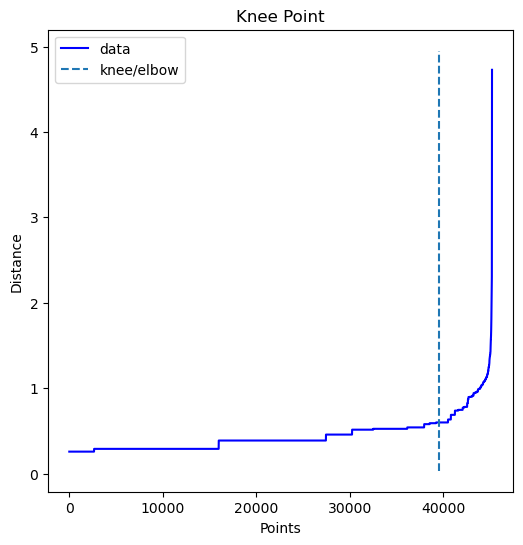

In [118]:
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [108]:
# set min_samples to N_features * 2
db = DBSCAN(eps=0.59, min_samples=12).fit(df_prepr)

labels = db.labels_

In [109]:
# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters)
print("Estimated number of noise points: %d" % n_noise)

Estimated number of clusters: 72
Estimated number of noise points: 3083
